# Marker analysis

In this notebook we will identify genes that are highly expressed in cells that feature a high mapping score. Furthermore, we will use the same method of differential expression test to ascertain the marker genes for each cluster in the reference SNN graph.

In [1]:
import nabo

We start by loading the mapped reference graph. Here we also visualize the mapping score for target **ME**:

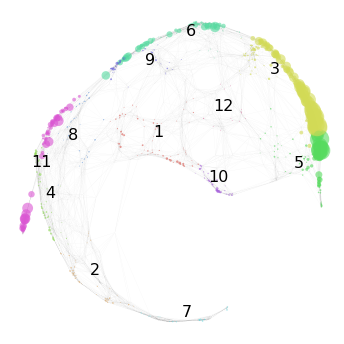

GraphPlot of 1414 nodes

In [2]:
hvg_graph = nabo.Graph()
hvg_graph.load_from_gml('../analysis_data/hvg_graph.gml')
nabo.GraphPlot(hvg_graph, vc_attr='cluster', label_attr='cluster',
               vs=hvg_graph.get_mapping_score(target='ME'))

Now we use [set_de_groups](../../../api.rst#nabo.Graph.set_de_groups) to identify marker genes for cells with a high mapping score. The parameter `min_score` sets the cutoff for mapping score and cells with higher score than this are marked as 'Test cells'. Using the optional parameter `from_clusters`, 'Test cell' selection can be restricted to certain clusters. The interesting aspect of [set_de_groups](../../../api.rst#nabo.Graph.set_de_groups) is how it selects the 'Control cells' to compare with 'Test cells'. 'Control cells' are selected based on their path distance from 'Test cells' on the graph. Each of the control cells will be no more than `node_dist` nodes away from 'Test cells'. Please [refer to the documentation](../../../api.rst#nabo.Graph.set_de_groups) for more information on other parameters that regulate 'Control cell' selection. At the end we visualize which cells were marked as test cells or control cells, respectively.

Test nodes: 70, Control nodes: 112


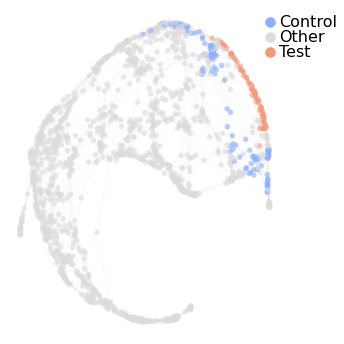

GraphPlot of 1414 nodes

In [3]:
hvg_graph.set_de_groups('ME', min_score=1, node_dist=2, from_clusters=['3'])
nabo.GraphPlot(hvg_graph, vc_attr='de_group', label_attr='de_group',
               label_attr_type='legend', cmap='coolwarm')

Since the graph object does not store the gene expression values, we use the [Dataset](../../../api.rst#dataset) class to load the data. This way we do not need to filter cells and genes again, or set size factors, because they were saved into the HDF5 file in the [Preprocessing notebook](1_preprocessing.ipynb).

In [4]:
wt_data = nabo.Dataset('../analysis_data/WT.h5')
me_data = nabo.Dataset('../analysis_data/MLL_ENL.h5')

INFO: Cached filtered cells loaded
INFO: Cached filtered genes loaded
INFO: Cached cell size factors loaded
INFO: Cached filtered cells loaded
INFO: Cached filtered genes loaded
INFO: Cached cell size factors loaded


Nabo keeps the [Dataset](../../../api.rst#dataset) class independent of the [Graph](../../../api.rst#graph) class, and hence the cell names saved in the Dataset object are not the same as those in the graph (because we appended reference names to them). So we save this info (not saved in HDF5) in a Dataset object so that it dynamically appends reference names to cells.

In [5]:
wt_data.update_exp_suffix(hvg_graph.refName)

Now we are ready to perform marker identification. Test cells are saved in `deTestCells` attribute and control cells in `deCtrlCells` attribute. We then call the [run_de_test](../../../api.rst#nabo.run_de_test) method to run the differential expression test (Mann-Whitney U test) between the two groups. The test will return a table containing names and other information for the genes with a significantly high expression in test cells. Please refer to the [documentation](../../../api.rst#nabo.run_de_test) to check out additional parameters that regulate the behaviour of this step.

The columns of this table are:

- `gene`: Gene name
- `exp_frac`: Fraction of test cells expressing (having non-zero value) this gene
- `test_group`: Name of test group. Can be ignored as we had only test group here.
- `versus_group`: Name of group against which the comparison was made. Can be ignored here as only one control group is defined here.
- `rbc`: Rank-biserial correlation
- `log_fc2`: Log2 fold change
- `pval`: p value
- `qval`: Benjamini-Hochberg corrected p value

In [6]:
wt_mapped_marker_table = nabo.run_de_test(
    wt_data, None,
    hvg_graph.deTestCells, [hvg_graph.deCtrlCells])
print (len(wt_mapped_marker_table), " DE genes found" )
wt_mapped_marker_table.head()

100%| 00:00

5  DE genes found


,gene,exp_frac,test_group,versus_group,rbc,log2_fc,pval,qval
0,GM10138,0.400000,Test group,Ctrl group 0,0.230204,1.338608,0.001611,0.009666
1,NCS1,0.257143,Test group,Ctrl group 0,0.162449,1.470816,0.006546,0.014850
2,KCNG1,0.257143,Test group,Ctrl group 0,0.157551,1.424919,0.008057,0.014850
3,ALG11,0.285714,Test group,Ctrl group 0,0.157143,1.085207,0.011832,0.014850
4,TDRD3,0.300000,Test group,Ctrl group 0,0.160000,1.080647,0.012375,0.014850


Expression of a gene can also be visualized on the graph using by setting `vc`, i.e. vertex color to the expression value of a gene (this value can be obtained using `wt_Data.exp.<gene>`). The `exp` attribute allows gene autocomplete functionality (this can be activated by writing at least one character after `exp.` and then pressing the TAB key). The graph below shows expression of FLT3, with darker hue representing higher expression.

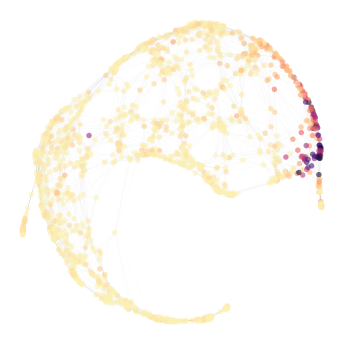

GraphPlot of 1414 nodes

In [7]:
nabo.GraphPlot(hvg_graph, vc=wt_data.exp.CTR9, cmap='magma_r', vc_percent_trim=1)

Expression distribution can also be visualized as boxplots using the `plot_box_exp` function:

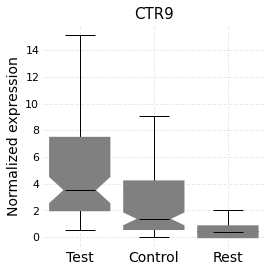

In [8]:
nabo.plot_box_exp(wt_data, 'CTR9',
                  [hvg_graph.deTestCells, hvg_graph.deCtrlCells],
                  ['Test', 'Control'])

The [run_de_test](../../../api.rst#nabo.run_de_test) method is quite flexible and can easily be used to compare the genes across datasets as well. As an example below, we test for upregulated genes in the WT cells marked as Test cells above, while comparing them to ME cells which were projected onto these WT cells. [Graph](../../../api.rst#graph) has a handy method called [get_mapped_cells](../../../api.rst#nabo.Graph.get_mapped_cells) which can be used to identify cells that project onto any set of reference cells.

In [9]:
mapped_wt_vs_me_table = nabo.run_de_test(
    wt_data,
    me_data,
    hvg_graph.deTestCells,
    [hvg_graph.get_mapped_cells('ME', hvg_graph.deTestCells)])
print (len(mapped_wt_vs_me_table), " DE genes found" )
mapped_wt_vs_me_table

100%| 00:00

12  DE genes found


,gene,exp_frac,test_group,versus_group,rbc,log2_fc,pval,qval
0,S100A9,1.000000,Test group,Ctrl group 0,1.000000,6.791093,1.018165e-26,1.323614e-25
1,S100A8,1.000000,Test group,Ctrl group 0,1.000000,4.865921,9.085780e-25,5.905757e-24
2,STFA1,0.800000,Test group,Ctrl group 0,0.797143,7.520187,2.966528e-20,1.285495e-19
3,BC100530,0.714286,Test group,Ctrl group 0,0.714286,inf,8.820606e-18,2.866697e-17
4,CHIL3,0.585714,Test group,Ctrl group 0,0.585714,inf,5.195727e-14,1.350889e-13
5,GM5483,0.585714,Test group,Ctrl group 0,0.578571,6.343146,1.601439e-13,3.469784e-13
6,NGP,0.471429,Test group,Ctrl group 0,0.471429,inf,5.004760e-11,9.294554e-11
7,GT(ROSA)26SOR,0.628571,Test group,Ctrl group 0,0.439592,2.050626,4.469200e-07,7.262450e-07
8,GPR183,0.314286,Test group,Ctrl group 0,0.304490,5.425057,7.354642e-07,1.062337e-06
9,CCR2,0.828571,Test group,Ctrl group 0,0.347755,1.016938,1.927641e-04,2.505934e-04


To look for upregulated genes the other way round, we simply switch the order of parameters as shown below.

In [10]:
mapped_me_vs_wt_table = nabo.run_de_test(
    me_data,
    wt_data,
    hvg_graph.get_mapped_cells('ME', hvg_graph.deTestCells),
    [hvg_graph.deTestCells])
print (len(mapped_me_vs_wt_table), " DE genes found" )
mapped_me_vs_wt_table.head(n=10)

100%| 00:00

310  DE genes found


,gene,exp_frac,test_group,versus_group,rbc,log2_fc,pval,qval
0,CAR2,0.985560,Test group,Ctrl group 0,0.982878,7.449399,7.105180e-43,2.209711e-40
1,CTLA2A,0.954272,Test group,Ctrl group 0,0.898814,4.413338,3.396180e-36,5.281060e-34
2,HOXA9,0.935018,Test group,Ctrl group 0,0.825890,2.857941,6.952826e-31,4.324658e-29
3,H2-D1,1.000000,Test group,Ctrl group 0,0.826784,1.405286,6.612265e-31,4.324658e-29
4,MEIS1,0.931408,Test group,Ctrl group 0,0.828657,2.973956,4.381979e-31,4.324658e-29
5,IKZF2,0.800241,Test group,Ctrl group 0,0.777549,5.359693,5.109443e-28,2.648395e-26
6,HOXA7,0.959085,Test group,Ctrl group 0,0.762902,2.030980,1.289349e-26,5.728393e-25
7,VAMP5,0.848375,Test group,Ctrl group 0,0.749527,3.351877,6.167713e-26,2.397699e-24
8,ADGRL4,0.740072,Test group,Ctrl group 0,0.734330,7.338323,1.538700e-25,5.317064e-24
9,CD34,0.960289,Test group,Ctrl group 0,0.737648,1.819609,5.253895e-25,1.633961e-23


Now let's identify marker genes for each reference graph cluster, using the [find_cluster_markers](../../../api.rst#nabo.find_cluster_markers) function. This returns two values. The first is a table containing a list of differentially expressed genes between each pair of clusters (in the same format as seen above). The same gene can occur multiple times as it will be tested for multiple pairs of clusters. The second returned value is a [dictionary](https://www.w3schools.com/python/python_dictionaries.asp) containing only names of marker genes as values and cluster number as keys. Here we call the [find_cluster_markers](../../../api.rst#nabo.find_cluster_markers) function with the following parameters:

- The cluster information from the Graph object (hvg_graph.clusters).
- Dataset object (wt_data)
- `de_frequency` (4). This value decides across how many cluster comparisons a gene should have a significant differential expression for it to be called a marker gene for a given cluster. For example, for FLT3 to be called a marker for cluster 2 it should come up at least 4 times as having a significantly high expression when compared to the rest of the clusters. A gene is allowed to be called a marker gene for more than one cluster.
- `exp_frac_thresh` (0.5). For a gene to be tested for a given cluster it should be expressed in at least 50% of the cells.
- `log_fc_thresh` (1). Gene should have $\log_2 (foldchange) \ >= \ 1$ for mean values.

In [11]:
marker_table, marker_genes = nabo.find_cluster_markers(
    hvg_graph.clusters, wt_data, de_frequency=4, exp_frac_thresh=0.5, log2_fc_thresh=1)

Finding markers for cluster 1: 100%| 00:00
Finding markers for cluster 10: 100%| 00:00
Finding markers for cluster 11: 100%| 00:00
Finding markers for cluster 12: 100%| 00:00
Finding markers for cluster 2: 100%| 00:00
Finding markers for cluster 3: 100%| 00:00
Finding markers for cluster 4: 100%| 00:00
Finding markers for cluster 5: 100%| 00:00
Finding markers for cluster 6: 100%| 00:00
Finding markers for cluster 7: 100%| 00:00
Finding markers for cluster 8: 100%| 00:00
Finding markers for cluster 9: 100%| 00:00


Let's check out how many genes marker genes were found for each cluster.

In [12]:
for cluster in marker_genes:
    print (cluster, len(marker_genes[cluster]))

1 190
10 222
11 64
12 97
2 243
3 175
4 159
5 316
6 88
7 304
8 91
9 58
